In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import train_test_split

from astropy import units as u
from astropy import constants
from astropy.cosmology import LambdaCDM, Planck18_arXiv_v2

from scipy.optimize import curve_fit
from scipy.stats import uniform
from scipy.stats import norm

import emcee
import corner

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

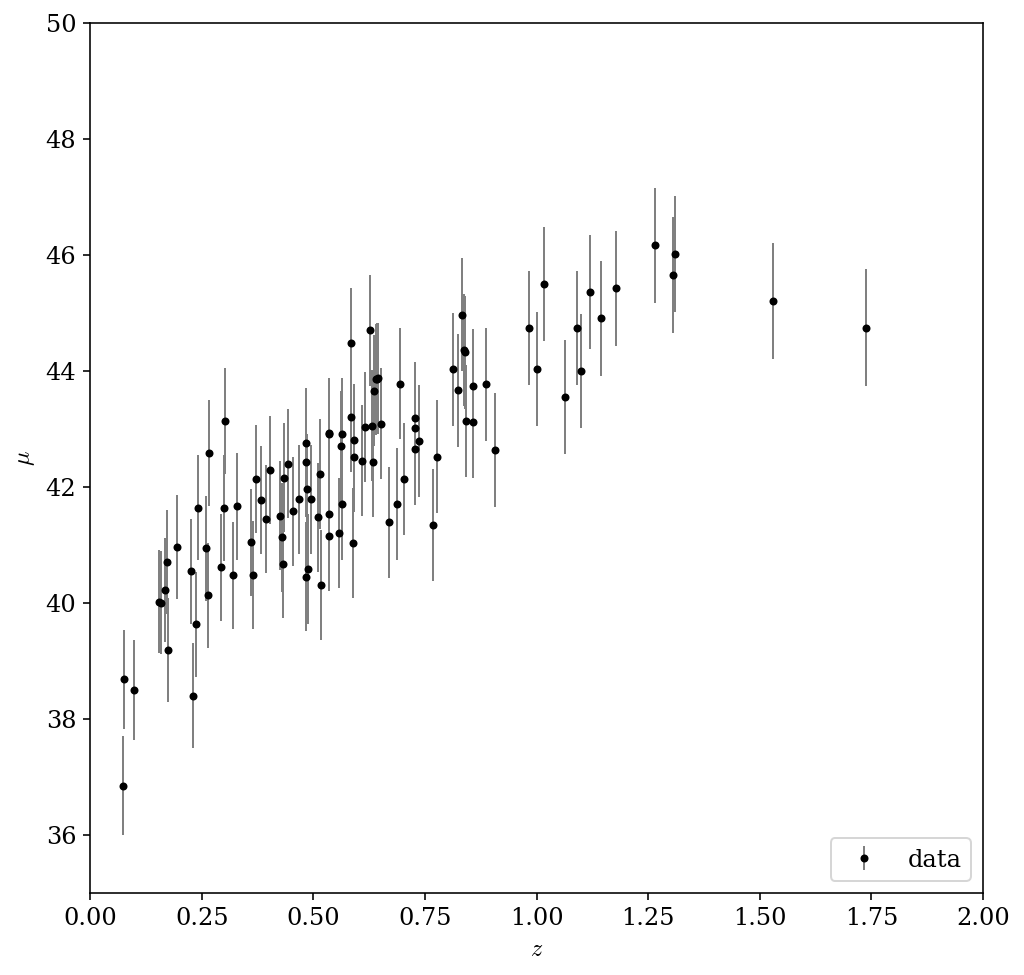

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

# Regression

In [3]:
z_sk = z_sample[:, np.newaxis] #z in the sklearn format

## Linear regression

In [4]:
linear_model = LinearRegression()
linear_model.fit(z_sk, mu_sample, dmu)

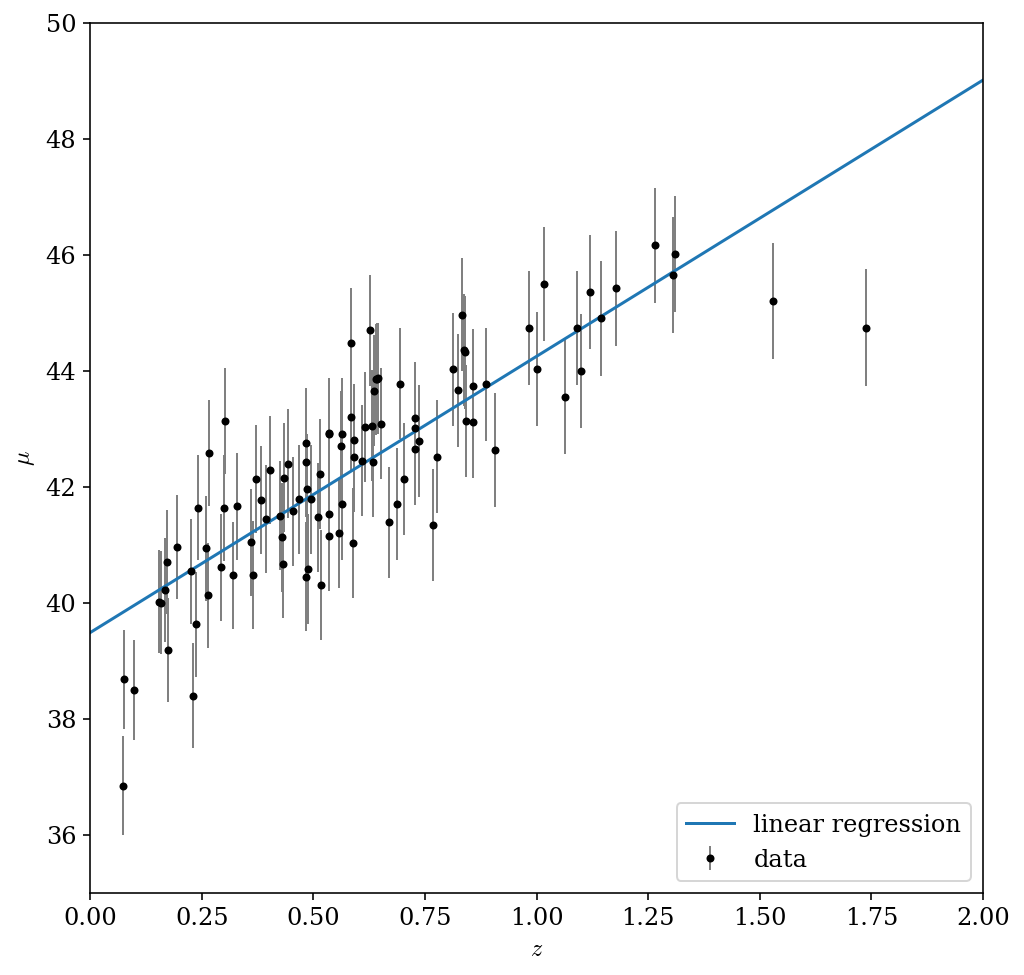

In [5]:
z_grid = np.linspace(0,2,100)[:, None]
mu_linear = linear_model.predict(z_grid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z_grid, mu_linear,label='linear regression')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

plt.show()

## Polynomial regression

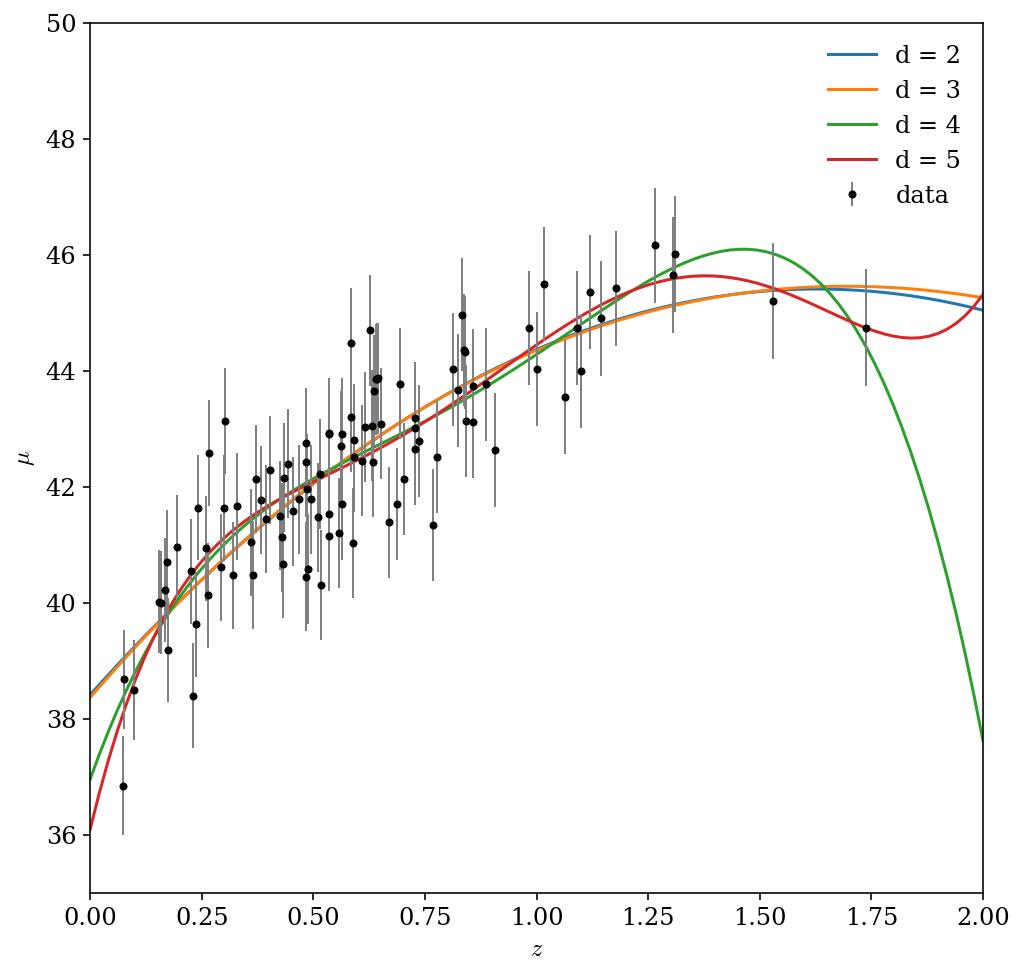

In [6]:
degrees = np.arange(2, 6)

for d in degrees:
    poly_model = PolynomialRegression(d)
    poly_model.fit(z_sk, mu_sample, dmu)
    mu_poly = poly_model.predict(z_grid)
    
    plt.plot(z_grid, mu_poly, label='d = %i' % d)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

d = 1 == underfitting  
d = 2, 3, 4 ?  
d = 5 == overfitting

## Basis function regression

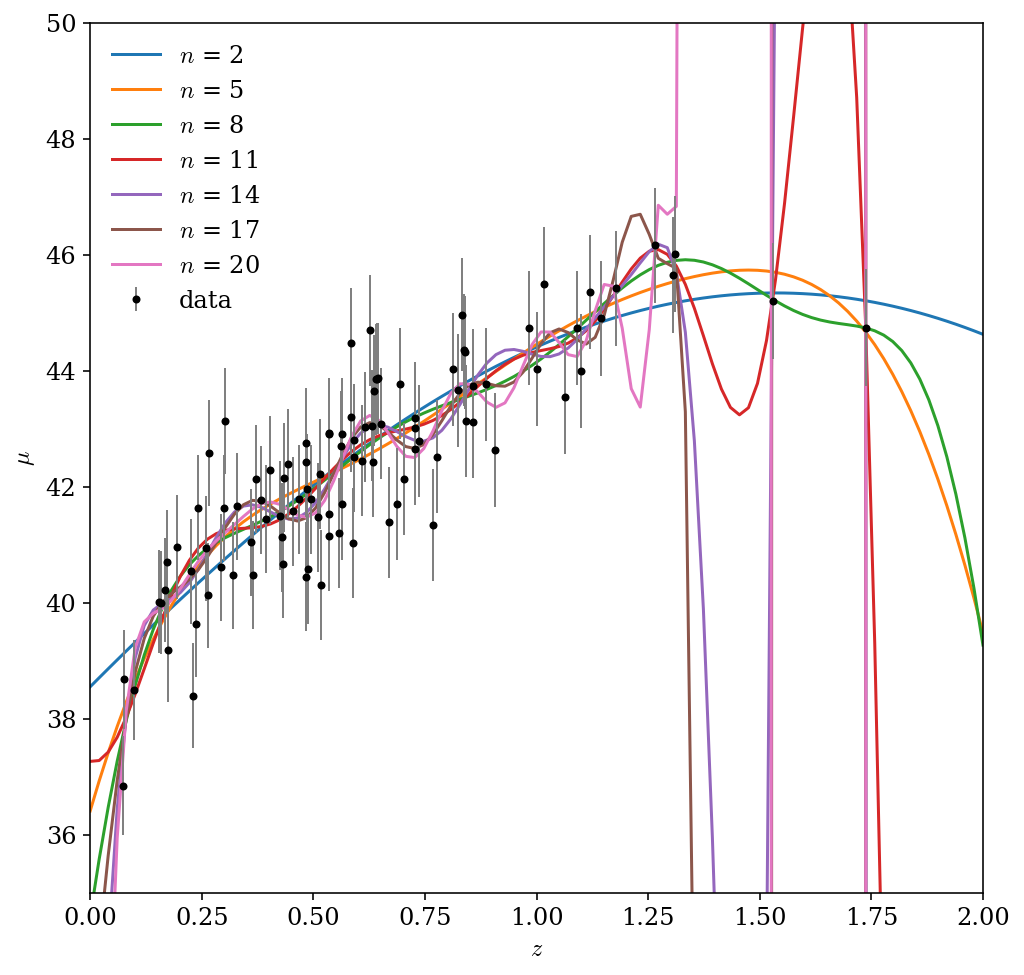

In [7]:
n_try = np.arange(2, 21, 3)
for n in n_try:
    mu_grid = np.linspace(0, 2, n)[:, np.newaxis]
    sigma = mu_grid[1] - mu_grid[0]
    basis_model = BasisFunctionRegression(basis_func='gaussian', mu = mu_grid, sigma = sigma)
    basis_model.fit(z_sk, mu_sample, dmu)
    mu_basis = basis_model.predict(z_grid)
    
    plt.plot(z_grid, mu_basis, label=r'$n$ = %.i' % n)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# Kernel regression

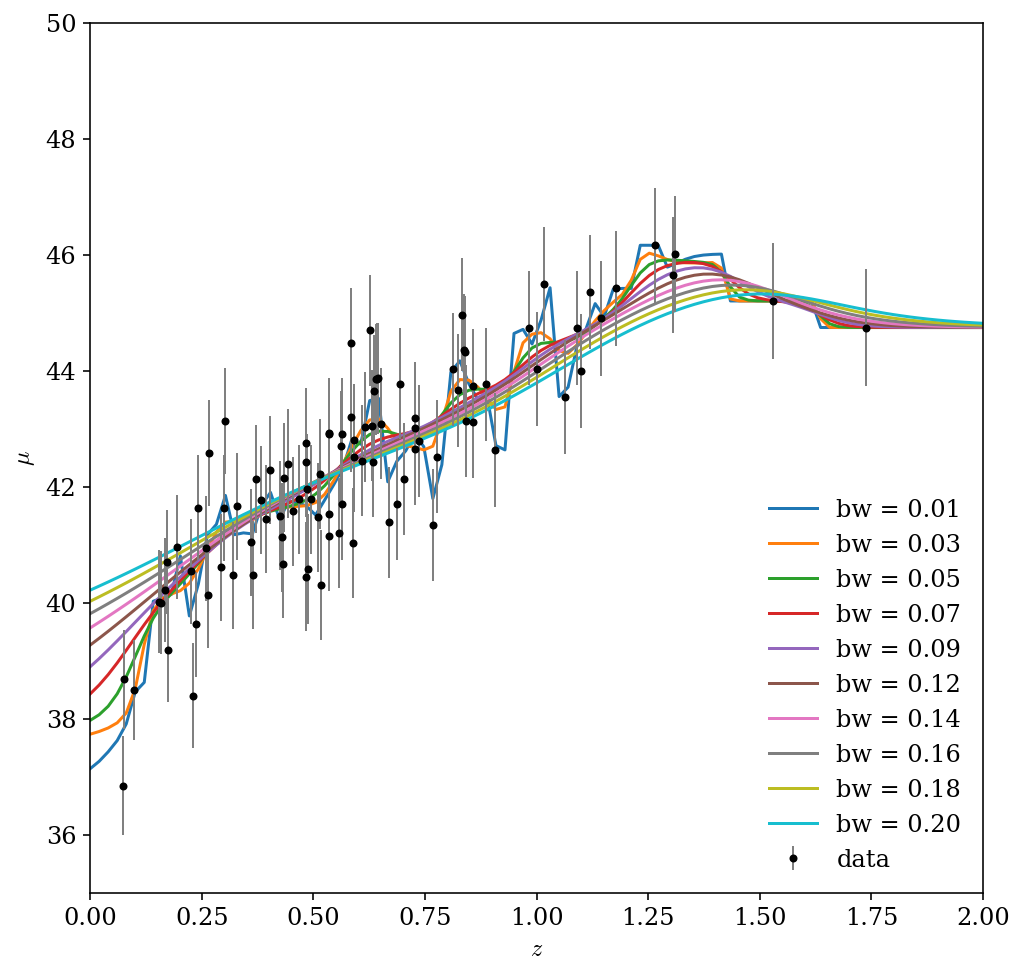

In [8]:
bw_try = np.linspace(0.01, 0.2, 10)
for bw in bw_try:
    
    kernel_model = NadarayaWatson(kernel='gaussian', h=bw)
    kernel_model.fit(z_sk, mu_sample)
    mu_kernel = kernel_model.predict(z_grid)
    
    plt.plot(z_grid, mu_kernel, label= 'bw = %.2f' % bw)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# Cross validation  

In [9]:
def error(y, x, model):
    return np.sqrt(np.sum((y - model.predict(x[:, np.newaxis]))**2) / len(x))

In [10]:
#K-fold cross validation 
K = 4
step = int(len(z_sample) / K)
indeces = np.arange(0, len(z_sample))
np.random.shuffle(indeces)
z_random = z_sample[indeces]
mu_random = mu_sample[indeces]
dmu_random = dmu[indeces]

## Polynomial

[5, 2, 5, 4]
best order: 4


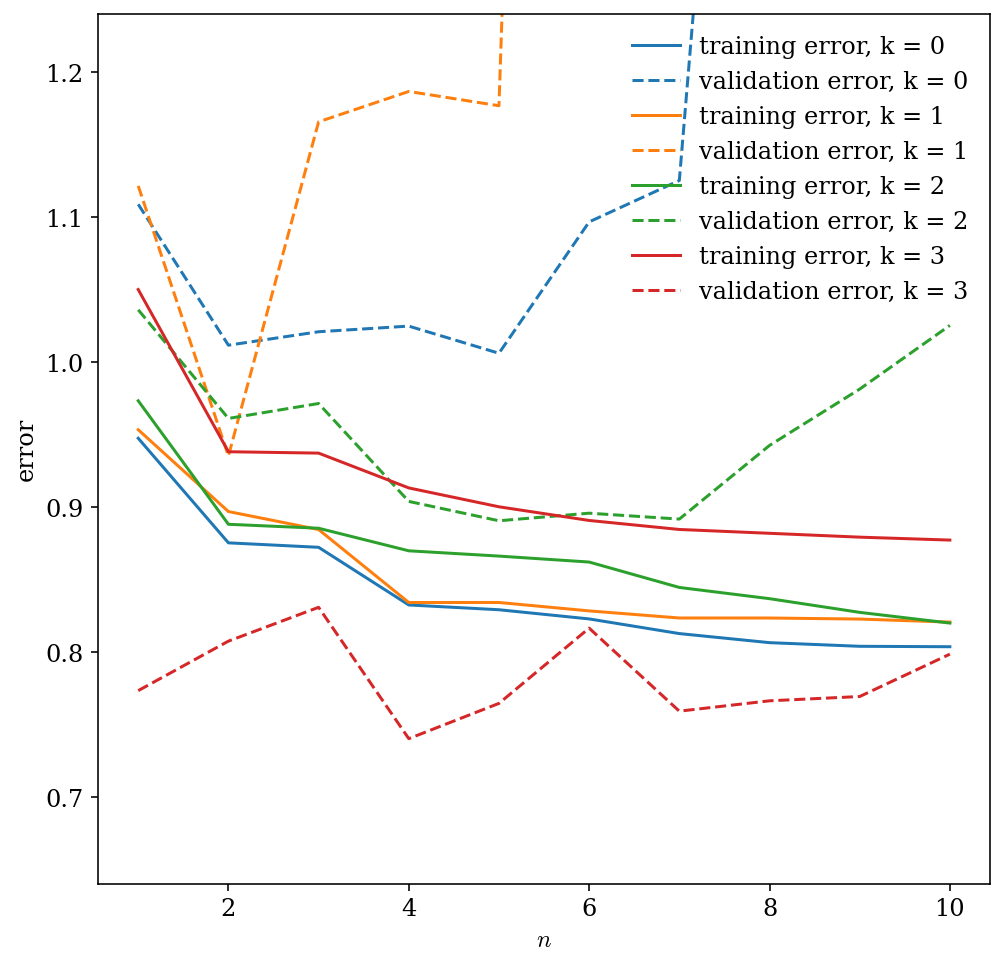

In [11]:
degrees = np.arange(1, 11)
d_list = []

for k in range(K):
    z_val = z_random[k*step:(k+1)*step]
    z_train = np.delete(z_random, np.arange(k*step, (k+1)*step), axis=0)
    
    mu_val = mu_random[k*step:(k+1)*step]
    mu_train = np.delete(mu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    dmu_val = dmu_random[k*step:(k+1)*step]
    dmu_train = np.delete(dmu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    err_train, err_val = [], []
    
    for d in degrees:
        model = PolynomialRegression(d)
        model.fit(z_train[:, np.newaxis], mu_train, dmu_train)
        err_train.append(error(mu_train, z_train, model))
        err_val.append(error(mu_val, z_val, model))
    d_list.append(degrees[np.argmin(err_val)])
    
    color = 'C' + str(k)
    plt.plot(degrees, err_train, c = color, label = 'training error, k = %.i' % k)
    plt.plot(degrees, err_val, ls = '--', c = color, label = 'validation error, k = %.i' % k)
    plt.ylim(min(min(err_train), min(err_val)) - 0.1, min(err_val) + 0.5) #better visualization 

d_best = int(np.mean(d_list))
print(d_list)
print('best order:', d_best)

plt.xlabel(r'$n$')
plt.ylabel('error')

plt.legend(frameon = False)
plt.show()

### polynomial regression with the best $d$

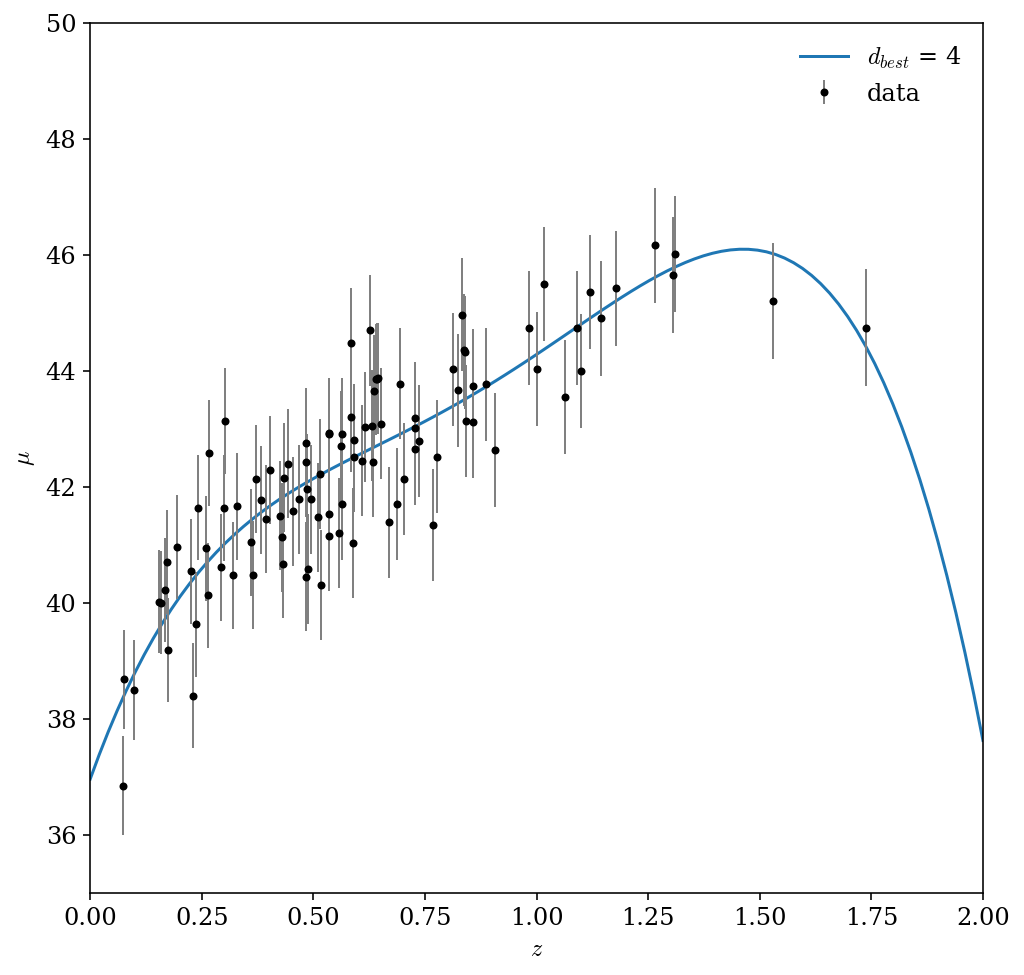

In [12]:
poly_model = PolynomialRegression(d_best)
poly_model.fit(z_sk, mu_sample, dmu)
mu_poly = poly_model.predict(z_grid)
    
plt.plot(z_grid, mu_poly, label=r'$d_{best}$ = %i' % d_best)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

Enough points in the training set? **learning curves**

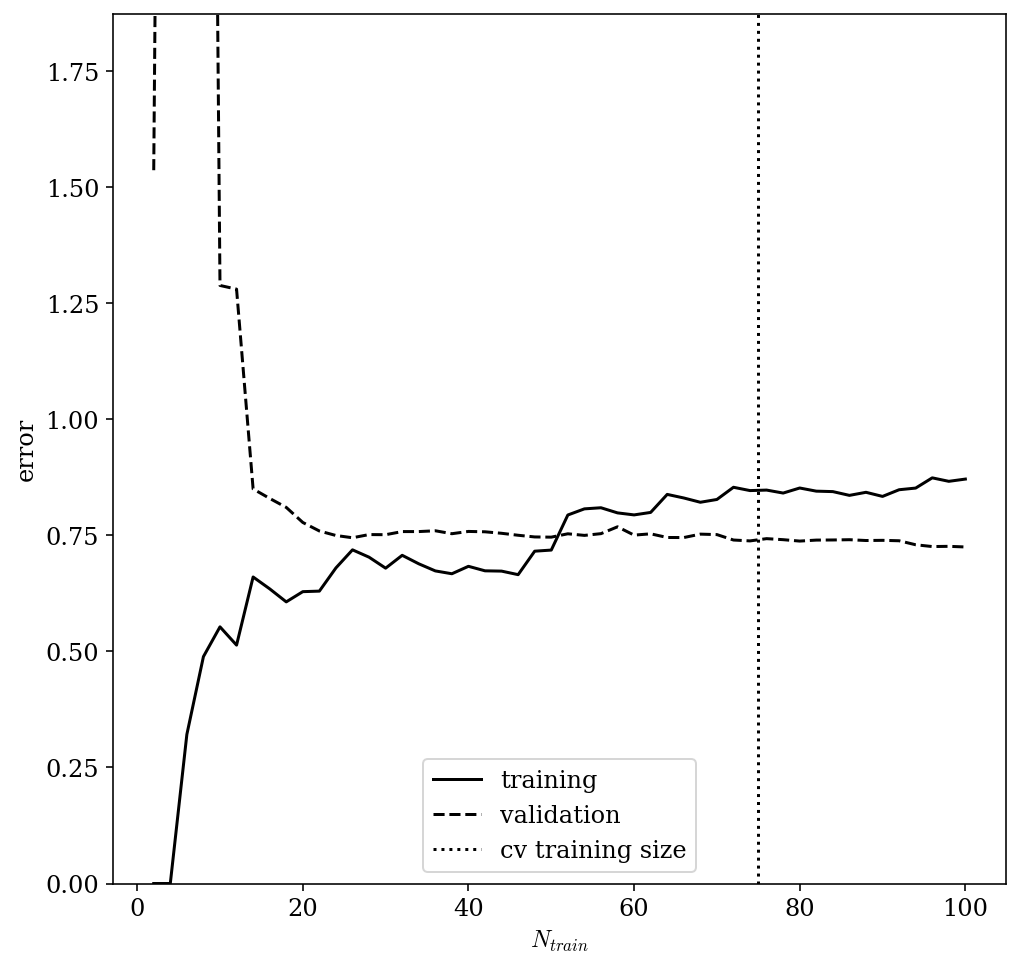

In [13]:
Nrange = np.arange(2, len(z_sample) + 1, 2)
poly_model = PolynomialRegression(d_best)
training_e = []
validation_e = []
for n in Nrange:
    poly_model.fit(z_sk[:n], mu_sample[:n], dmu[:n])
    training_e.append(error(mu_sample[:n], z_sample[:n], poly_model))
    validation_e.append(error(mu_val, z_val, poly_model))

plt.plot(Nrange, training_e, c='k', label='training')
plt.plot(Nrange, validation_e, c='k', ls='--', label='validation')

plt.axvline(len(z_train), c = 'k', ls = ':', label = 'cv training size')

plt.xlabel(r'$N_{train}$')
plt.ylabel('error')
plt.ylim(0, max(training_e) + 1)

plt.legend()
plt.show()

In [14]:
#check if the last points raise the order of the polynomial
N = 30 
degrees = np.arange(1, 11)
d_list_small = []
d_list_big = []

for n in range(N):
    z_train, z_val, mu_train, mu_val, dmu_train, dmu_val = train_test_split(z_sample, mu_sample, dmu, test_size = 0.3, random_state = None)
    err_train, err_val = [], []
    for d in degrees:
        poly_model = PolynomialRegression(d)
        poly_model.fit(z_train[:, np.newaxis], mu_train, dmu_train)
        err_train.append(error(mu_train, z_train, poly_model))
        err_val.append(error(mu_val, z_val, poly_model))
    d_list.append(degrees[np.argmin(err_val)])
    if((z_train > 1.5).any()):
        d_list_big.append(degrees[np.argmin(err_val)])
        print('z > 1.5 in training set -> n = %.i' % degrees[np.argmin(err_val)])
    else:
        d_list_small.append(degrees[np.argmin(err_val)])
d_best = int(np.mean(d_list_small + d_list_big))
print('if neither of the last two points is present in the training set the orders are:', d_list_small)
print('best order:', d_best)

z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 8
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 4
z > 1.5 in training set -> n = 1
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 7
z > 1.5 in training set -> n = 6
z > 1.5 in training set -> n = 2
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 5
z > 1.5 in training set -> n = 2
if neither of the last two points is present in the training set the orders 

high $n$ can't be reached without at least one of the last two points in the training set  
the presence of at least one of the last two points in the training set does **not** guarantee a high $n$

## Basis

[7, 2, 5, 4]
the best n is: 4


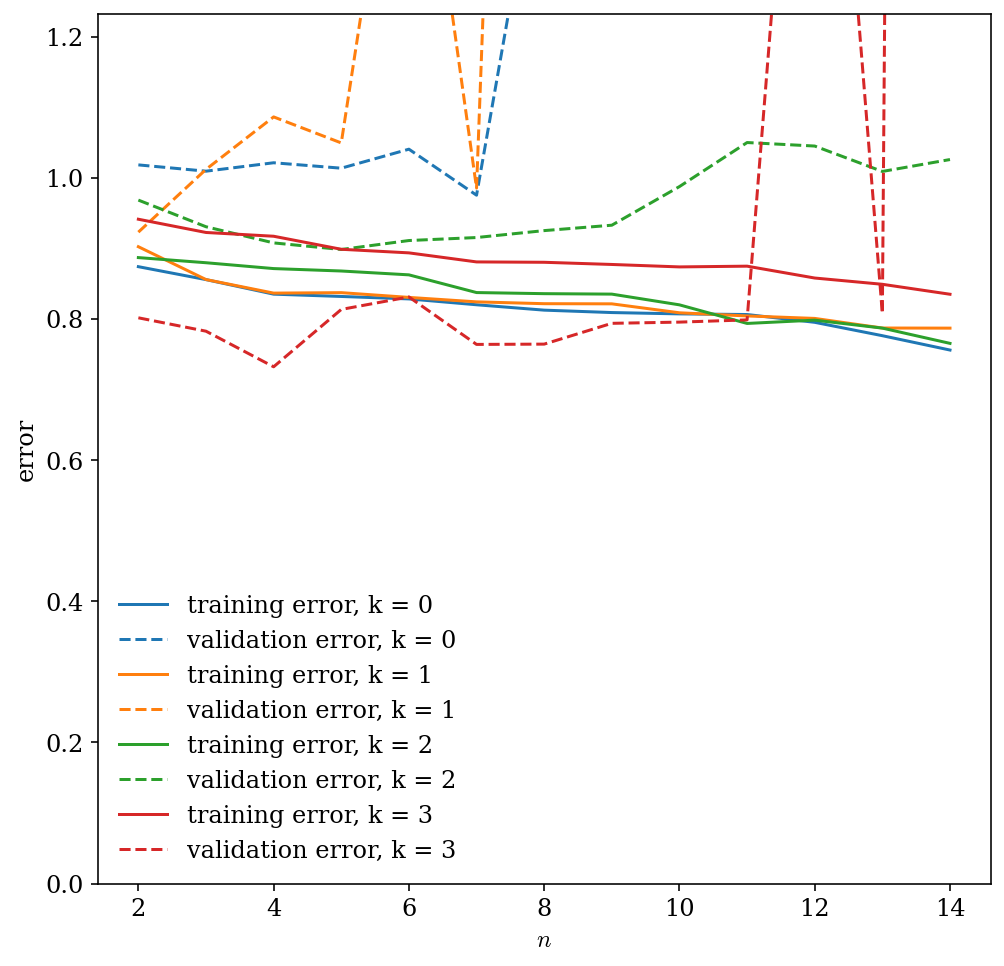

In [15]:
n_try  = np.arange(2, 15)
n_list = []

for k in range(K):
    z_val = z_random[k*step:(k+1)*step]
    z_train = np.delete(z_random, np.arange(k*step, (k+1)*step), axis=0)
    
    mu_val = mu_random[k*step:(k+1)*step]
    mu_train = np.delete(mu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    dmu_val = dmu_random[k*step:(k+1)*step]
    dmu_train = np.delete(dmu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    err_train, err_val = [], []
    
    for n in n_try:
        mu_grid = np.linspace(0, 2, n)[:, np.newaxis]
        sigma = mu_grid[1] - mu_grid[0]
        model = BasisFunctionRegression(basis_func='gaussian', mu = mu_grid, sigma = sigma)
        model.fit(z_train[:, np.newaxis], mu_train, dmu_train)
        err_train.append(error(mu_train, z_train, model))
        err_val.append(error(mu_val, z_val, model))
    n_list.append(n_try[np.argmin(err_val)])
    
    color = 'C' + str(k)
    plt.plot(n_try, err_train, c = color, label = 'training error, k = %.i' % k)
    plt.plot(n_try, err_val, ls = '--', c = color, label = 'validation error, k = %.i' % k)
    plt.ylim(0, min(err_val) + 0.5) #better visualization 

n_best = int(np.mean(n_list))
print(n_list)
print('the best n is:', n_best)

plt.xlabel(r'$n$')
plt.ylabel('error')

plt.legend(frameon = False)
plt.show()

### basis regression with the best $n$

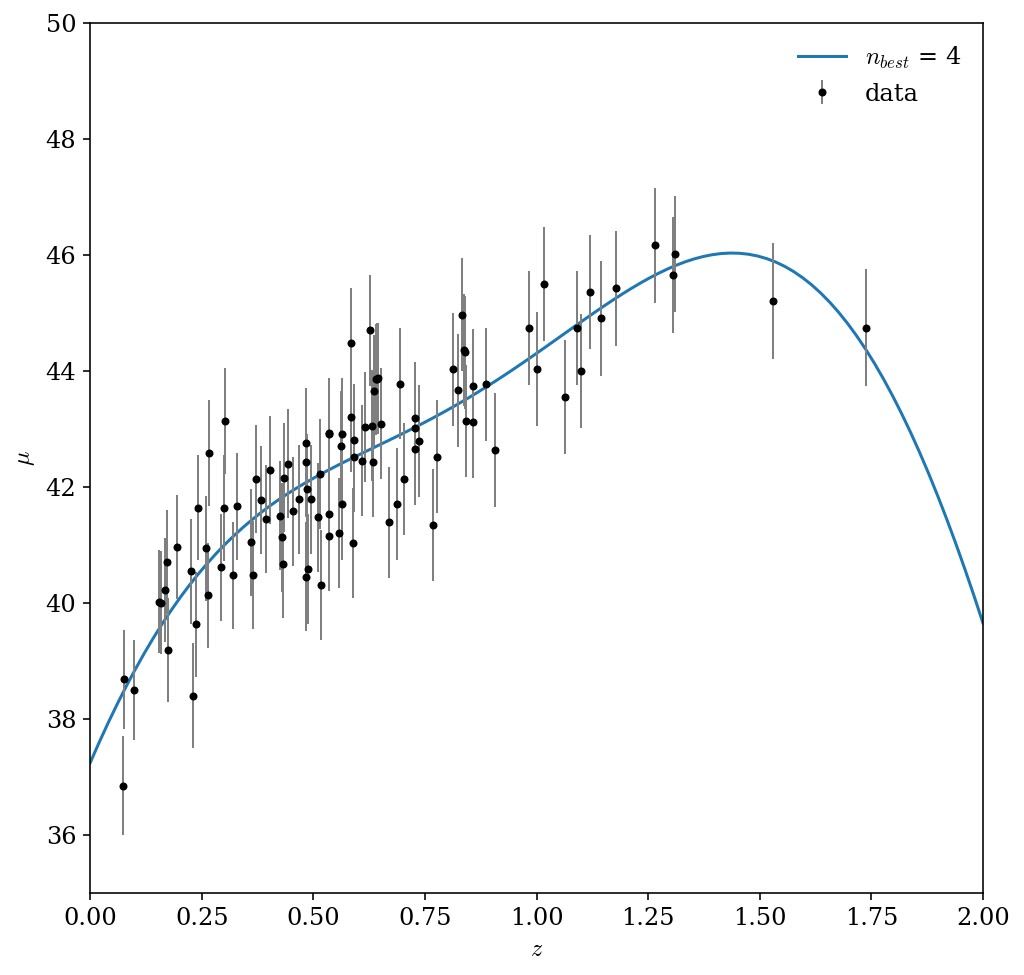

In [16]:
mu_grid = np.linspace(0, 2, n_best)[:, np.newaxis]
sigma = mu_grid[1] - mu_grid[0]
basis_model = BasisFunctionRegression(basis_func='gaussian', mu = mu_grid, sigma = sigma)
basis_model.fit(z_sk, mu_sample, dmu)
mu_basis = basis_model.predict(z_grid)
    
plt.plot(z_grid, mu_basis, label=r'$n_{best}$ = %.i' % n_best)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

## Kernel

[0.06000000000000001, 0.04000000000000001, 0.08000000000000002, 0.06000000000000001]
the best bw is: 0.06000000000000001


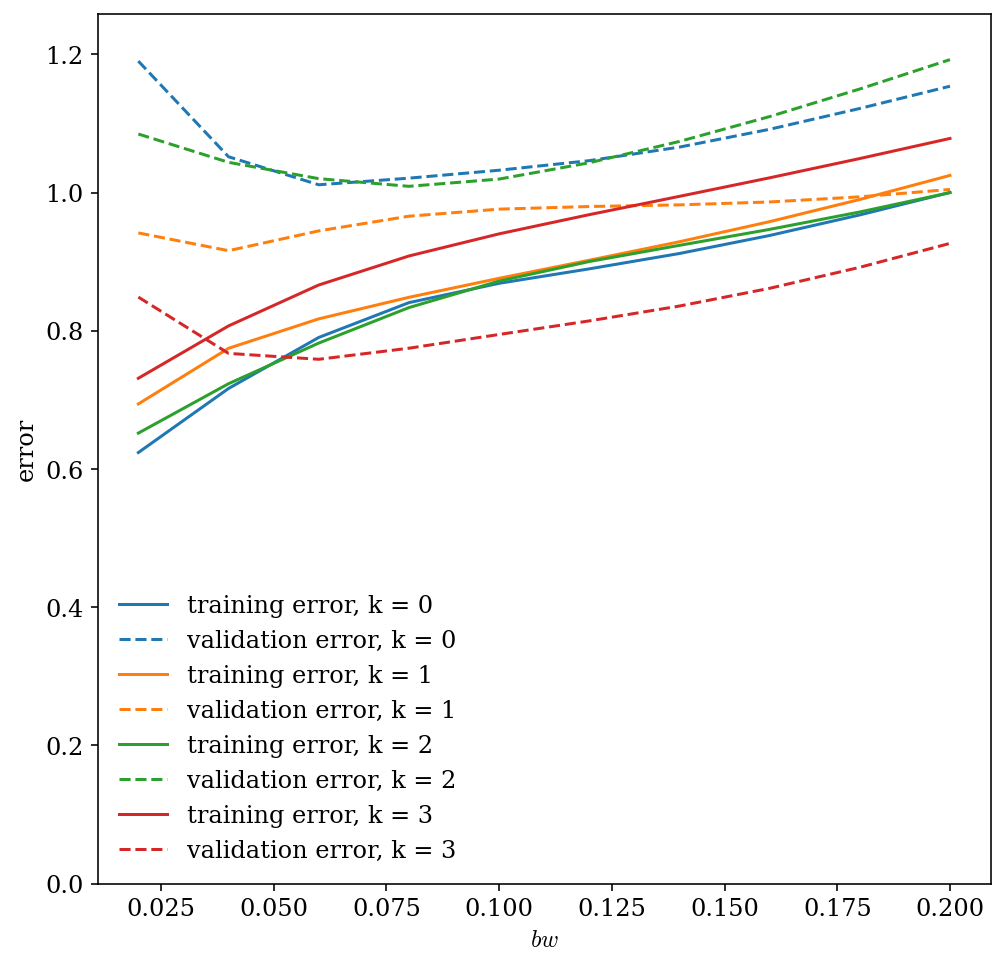

In [17]:
bw_try  = bw_try = np.linspace(0.02, 0.2, 10)
bw_list = []

for k in range(K):
    z_val = z_random[k*step:(k+1)*step]
    z_train = np.delete(z_random, np.arange(k*step, (k+1)*step), axis=0)
    
    mu_val = mu_random[k*step:(k+1)*step]
    mu_train = np.delete(mu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    dmu_val = dmu_random[k*step:(k+1)*step]
    dmu_train = np.delete(dmu_random, np.arange(k*step, (k+1)*step), axis=0)
    
    err_train, err_val = [], []
    
    for bw in bw_try:
        model = NadarayaWatson(kernel='gaussian', h=bw)
        model.fit(z_train[:, np.newaxis], mu_train)
        err_train.append(error(mu_train, z_train, model))
        err_val.append(error(mu_val, z_val, model))
    bw_list.append(bw_try[np.argmin(err_val)])
    
    color = 'C' + str(k)
    plt.plot(bw_try, err_train, c = color, label = 'training error, k = %.i' % k)
    plt.plot(bw_try, err_val, ls = '--', c = color, label = 'validation error, k = %.i' % k)
    plt.ylim(0, min(err_val) + 0.5) #better visualization 

bw_best = np.mean(bw_list)
print(bw_list)
print('the best bw is:', bw_best)

plt.xlabel(r'$bw$')
plt.ylabel('error')

plt.legend(frameon = False)
plt.show()

### kernel regression with the best bandwidth

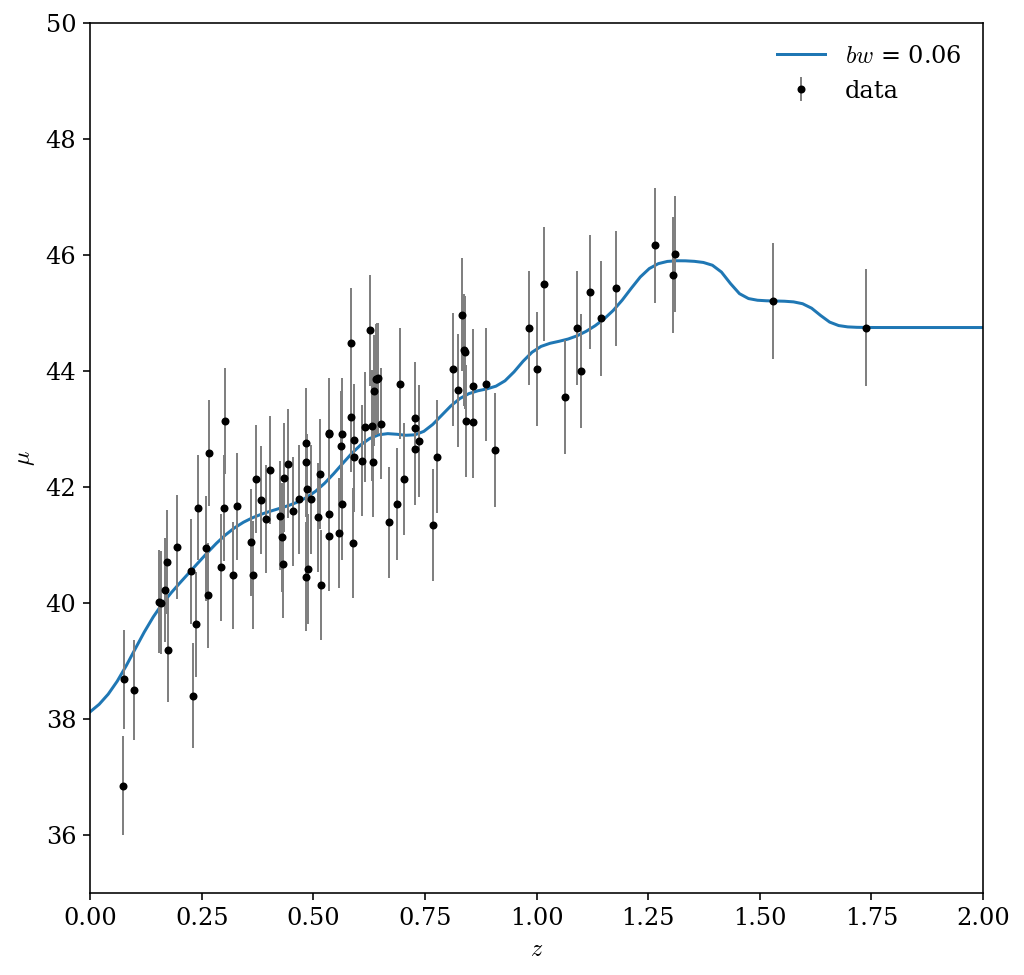

In [18]:
kernel_model = NadarayaWatson(kernel='gaussian', h=bw_best)
kernel_model.fit(z_sk, mu_sample)
mu_kernel = kernel_model.predict(z_grid)
    
plt.plot(z_grid, mu_kernel, label=r'$bw$ = %.2f' % bw_best)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# PART 2

## GPR

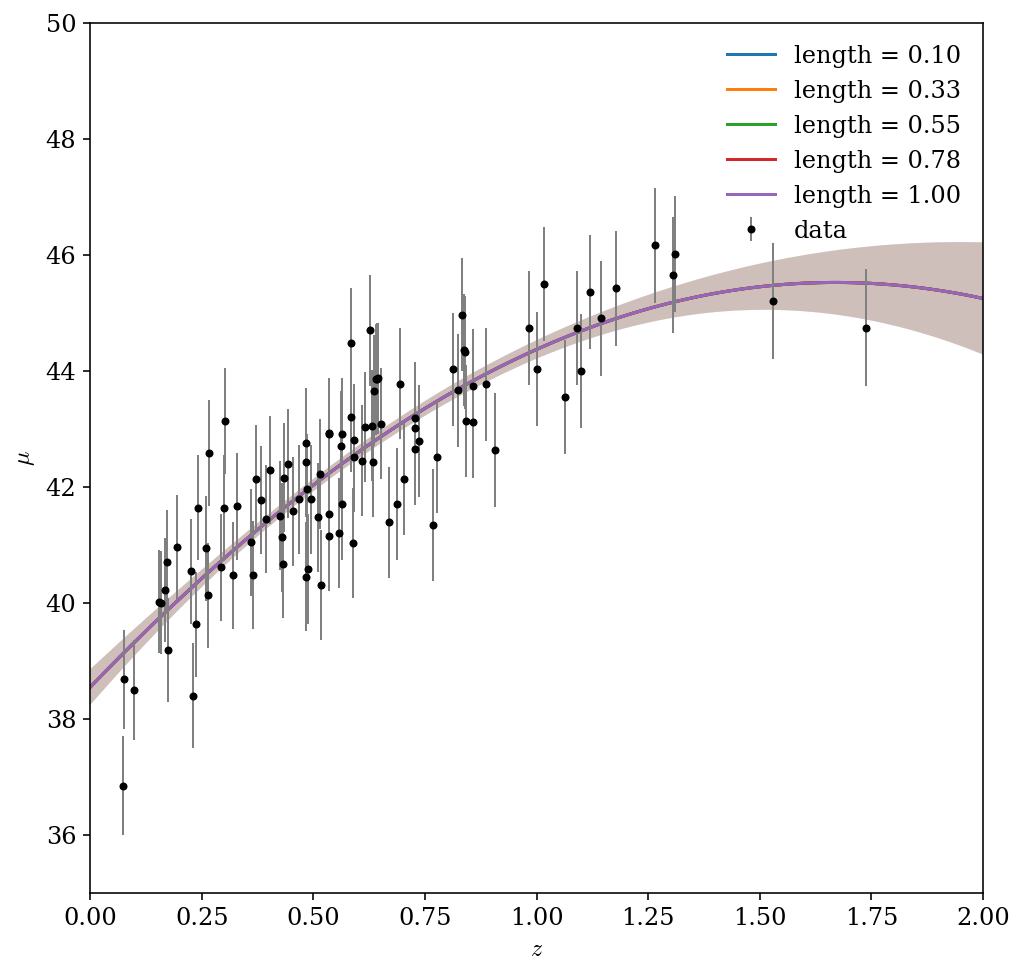

In [19]:
length_scales = np.linspace(0.1, 1, 5)
for length_scale in length_scales:
    kernel = kernels.ConstantKernel(1.0) * kernels.RBF(length_scale)
    gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2)
    gpr.fit(z_sk, mu_sample)
    mu_gpr, mu_sigma = gpr.predict(z_grid, return_std=True)
    
    plt.plot(z_grid, mu_gpr, label= 'length = %.2f' % length_scale)
    plt.fill_between(z_grid[:,0], mu_gpr - mu_sigma, mu_gpr + mu_sigma, alpha = 0.1)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

implement the cross validation

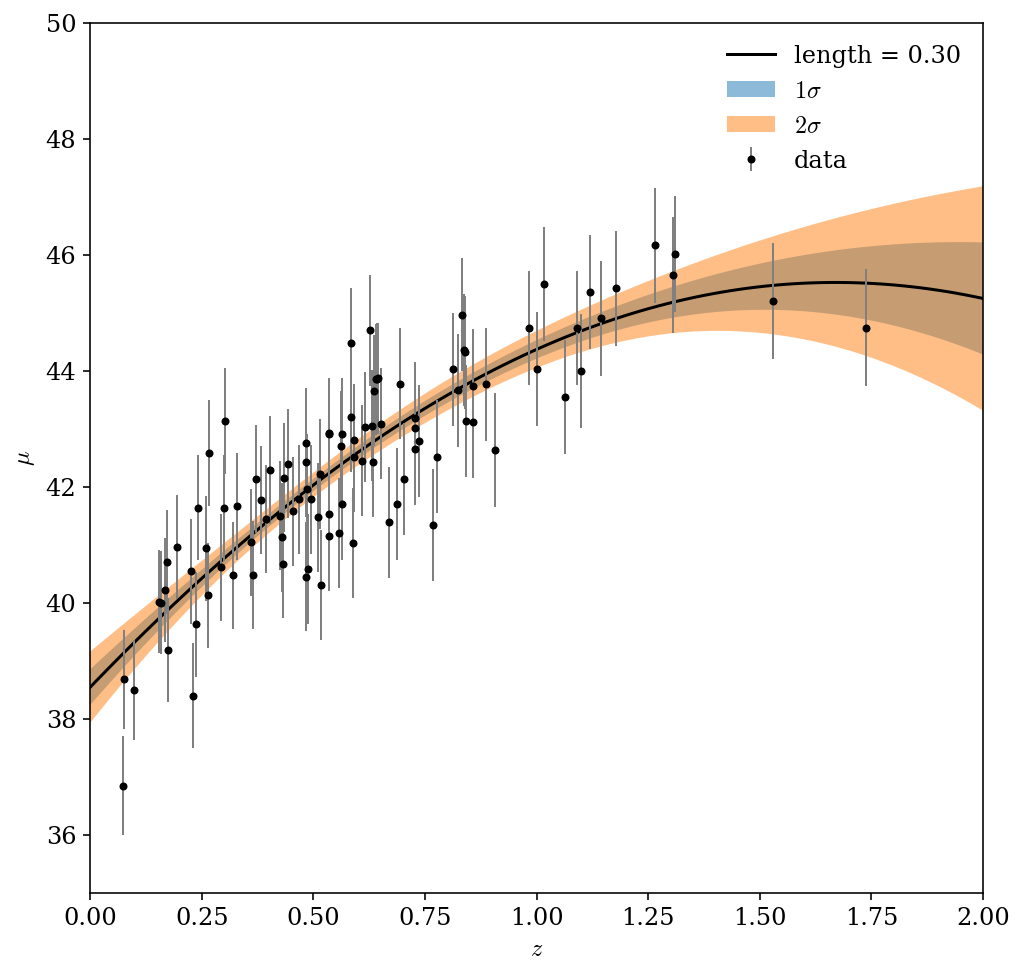

In [20]:
length_scale = 0.3
kernel = kernels.ConstantKernel(1.0) * kernels.RBF(length_scale)
gpr = GaussianProcessRegressor(kernel = kernel, alpha = dmu**2)
gpr.fit(z_sk, mu_sample)
mu_gpr, mu_sigma = gpr.predict(z_grid, return_std=True)
    
plt.plot(z_grid, mu_gpr, c = 'k', label = 'length = %.2f' % length_scale)
plt.fill_between(z_grid[:,0], mu_gpr - mu_sigma, mu_gpr + mu_sigma, alpha = 0.5, label = r'$1\sigma$')
plt.fill_between(z_grid[:,0], mu_gpr - 2*mu_sigma, mu_gpr + 2*mu_sigma, alpha = 0.5, label = r'$2\sigma$')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

# $\Lambda$CDM model

$\mu = 5\log(\frac{c / H_0}{10\,pc} (1+z) \int_0^z \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}})$  

In [21]:
def model(z, H0 ,Om):
    cosmology = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmology.distmod(z).value

In [22]:
def loglikelihood(theta):
    H0, Om = theta
    if Om > 0:
        mu_model = model(z_sample, H0, Om)
        return np.sum(norm(loc=mu_model, scale=dmu).logpdf(mu_sample))
    if Om < 0:
        return -np.inf

In [24]:
def prior_from_u(u):
    x = np.array(u)
    H0_min, H0_max = 40, 100
    Om_min, Om_max = 0.2, 1
    x[0] =  uniform(loc=H0_min, scale=(H0_max - H0_min)).ppf(u[0])
    x[1] =  uniform(loc=Om_min, scale=(Om_max - Om_min)).ppf(u[1])
    return x

In [30]:
ndim = 2
sampler = dynesty.NestedSampler(loglikelihood, prior_from_u, ndim, nlive=1000) 
sampler.run_nested()
results = sampler.results

2647it [01:49, 24.19it/s, +1000 | bound: 0 | nc: 1 | ncall: 14361 | eff(%): 25.395 | loglstar:   -inf < -132.814 <    inf | logz: -135.173 +/-  0.025 | dlogz:  0.001 >  1.009]


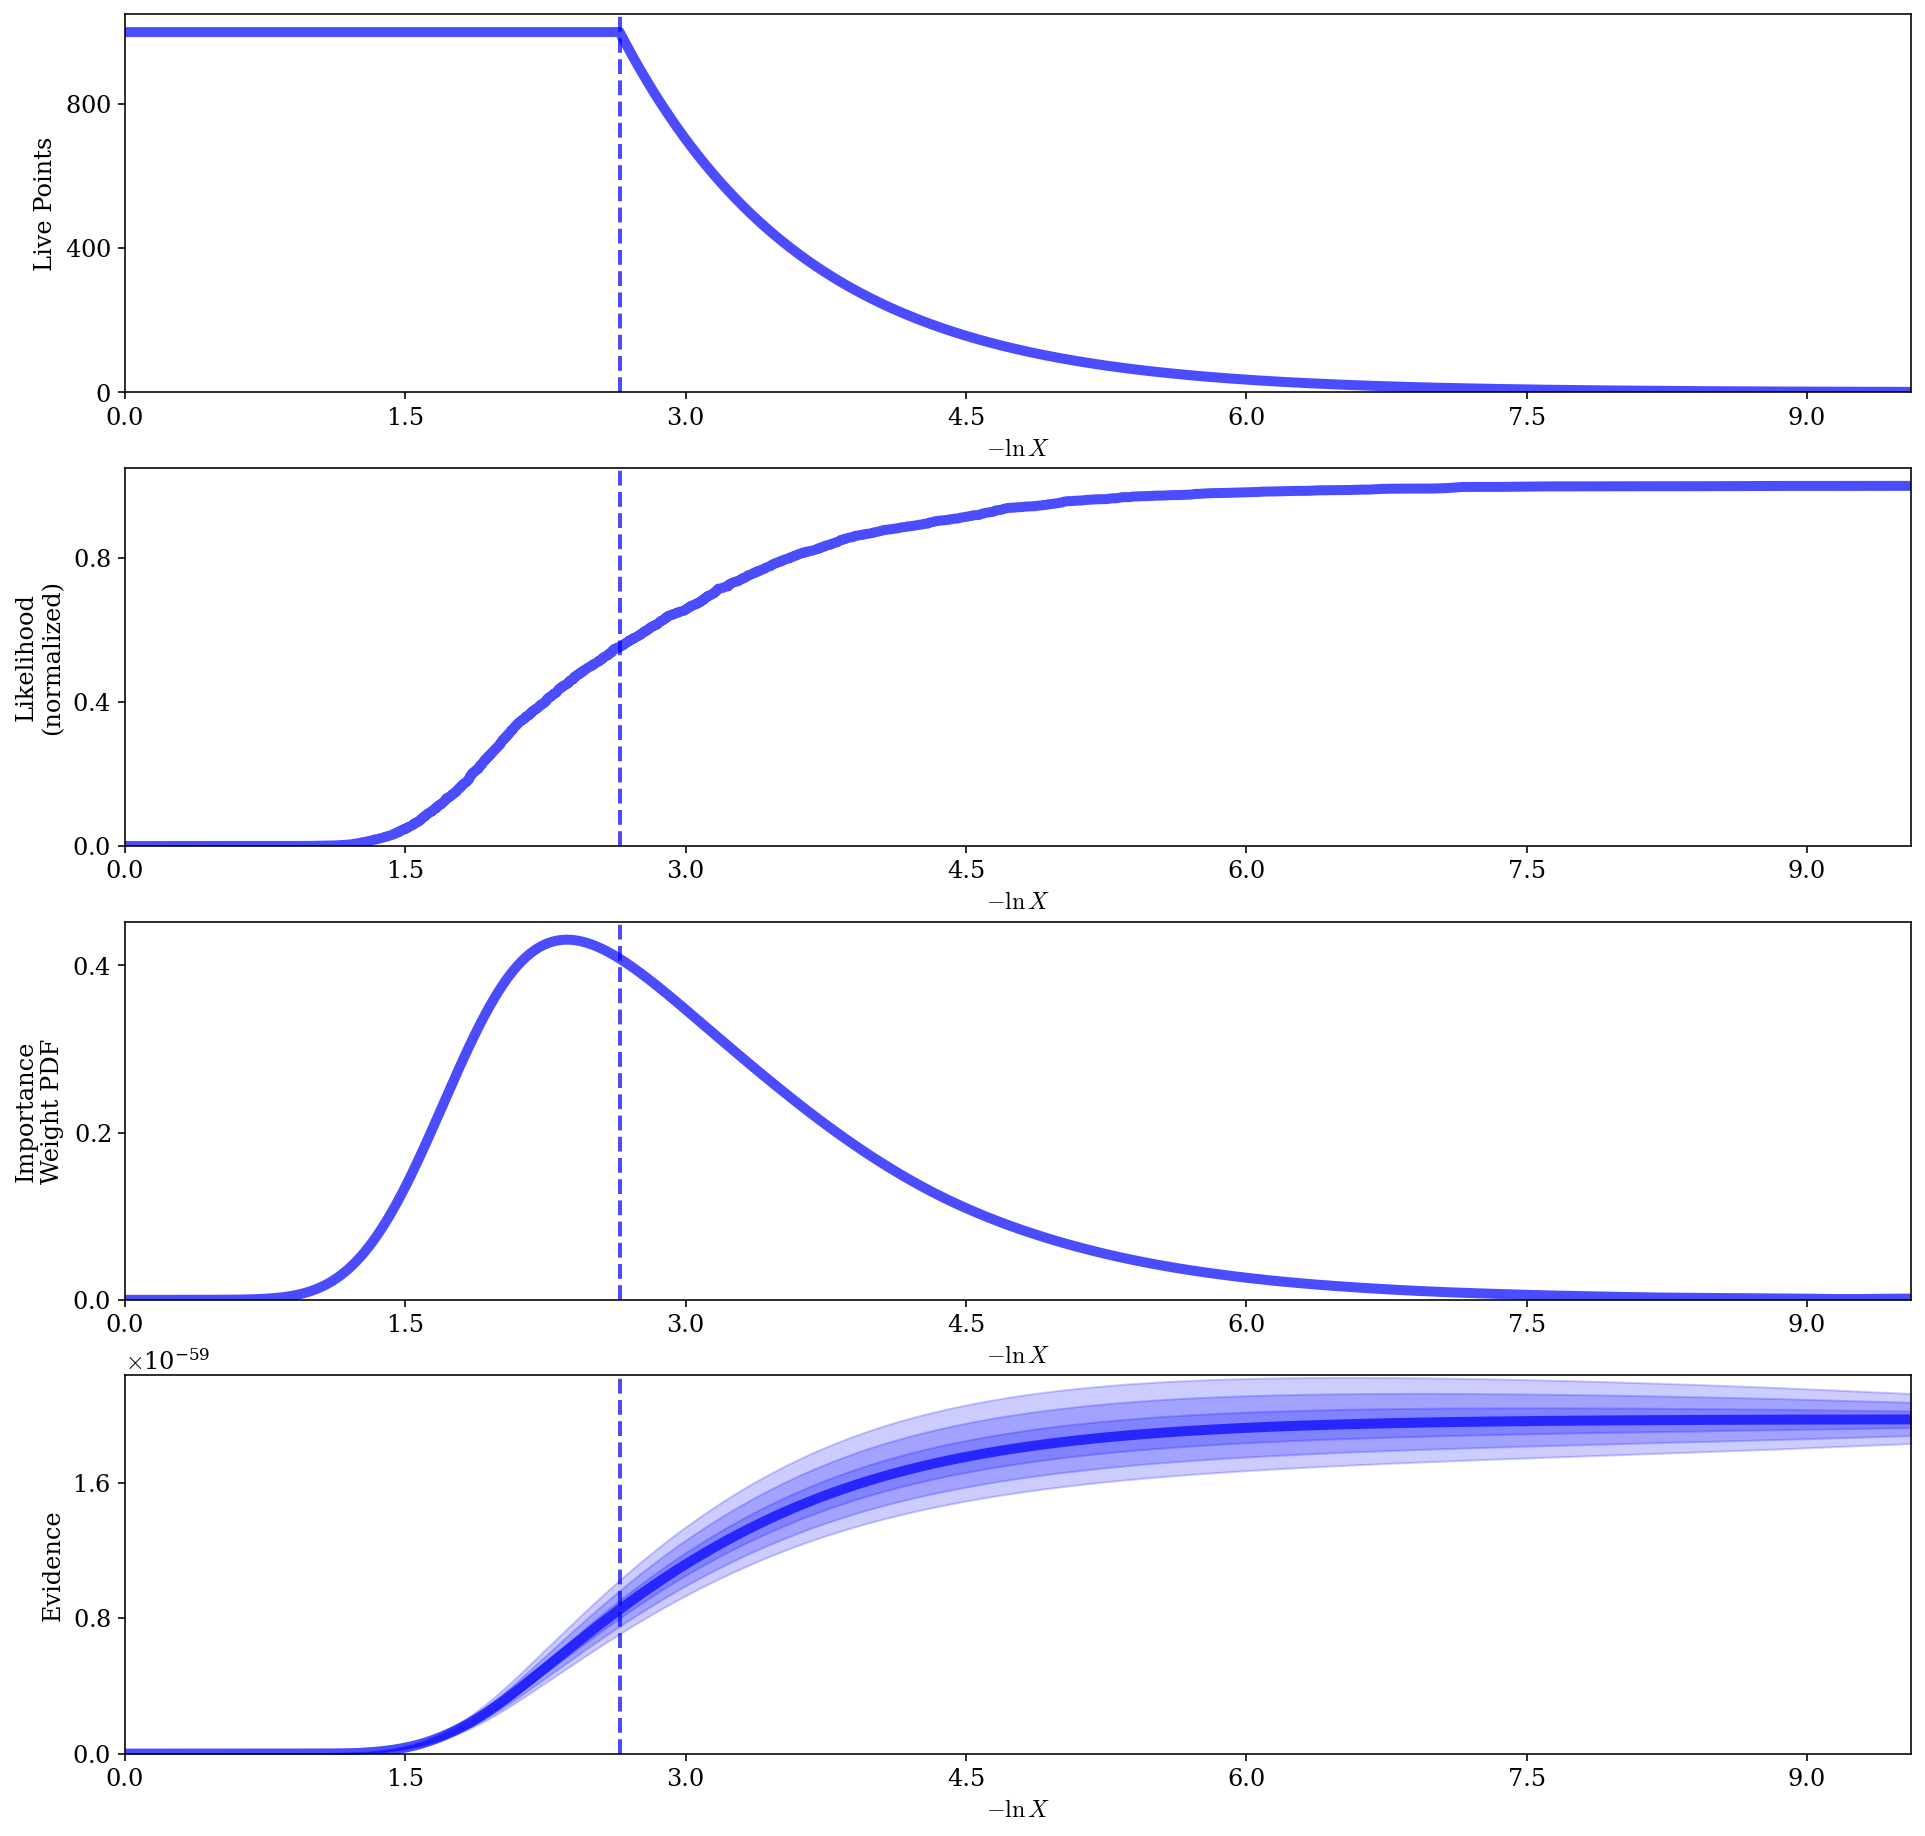

In [31]:
rfig, raxes = dyplot.runplot(results)

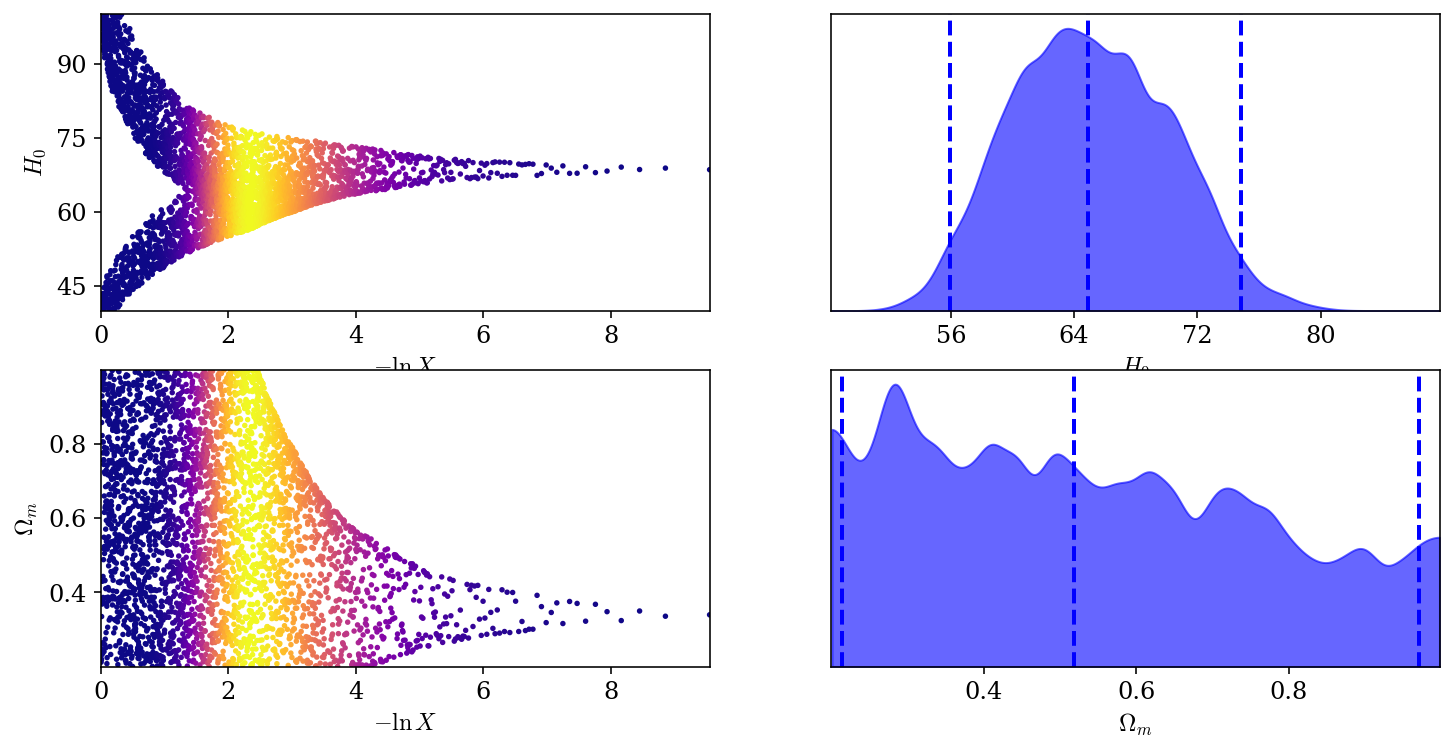

In [32]:
tfig, taxes = dyplot.traceplot(results, labels=['$H_0$', '$\Omega_m$'])

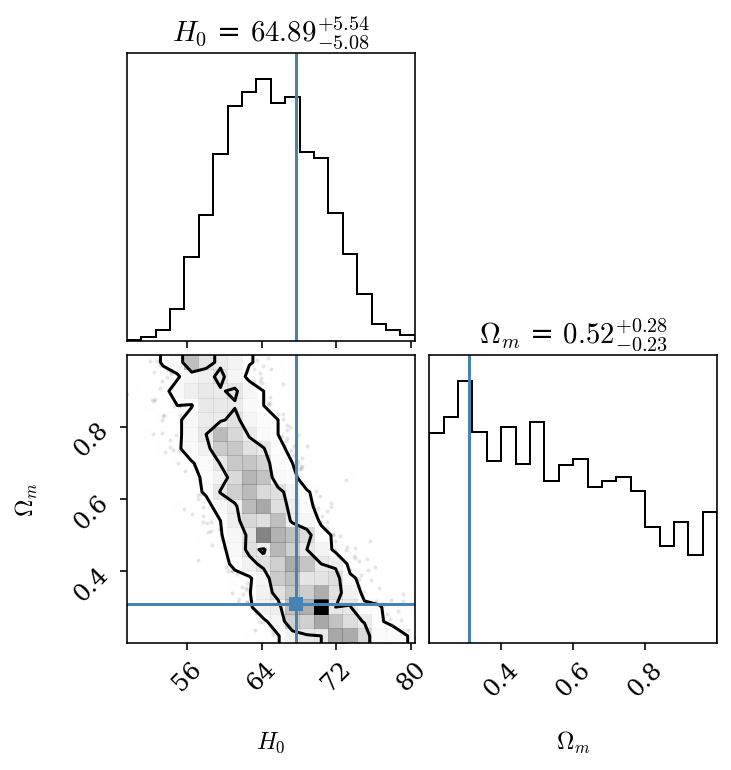

In [33]:
#corner plot
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)
labels = [r'$H_0$', r'$\Omega_m$']

planck = Planck18_arXiv_v2 #actual cosmological measures
true_vals = [planck.H0.value, planck.Om0]
fig = corner.corner(
    samples_equal, labels=labels, levels=[0.68,0.95], show_titles=True, truths=true_vals
);

$H_0$ and $\Omega_m$ seems to be correlated, there is a preferential direction in the $H_0 - \Omega_m$ plane.

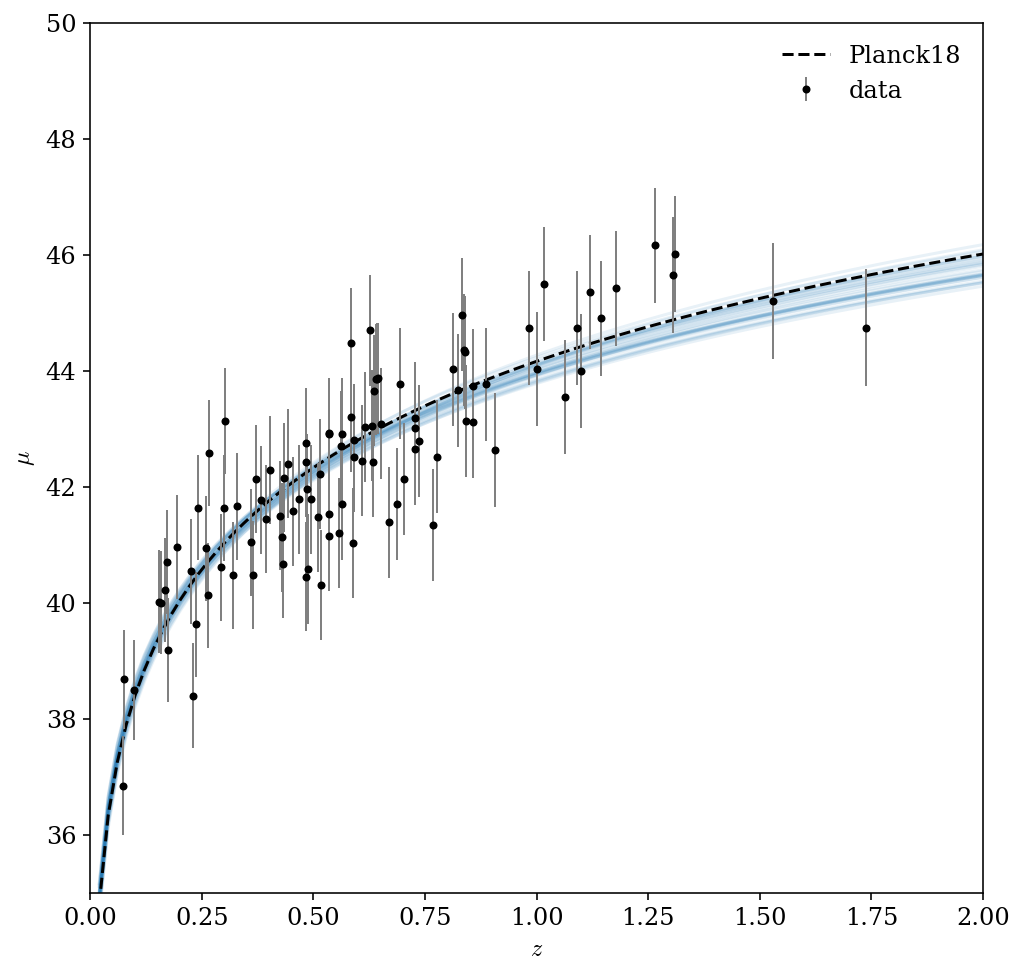

In [34]:
# 30 random samples to plot
N_rand = 30
mask = np.random.choice(len(samples_equal), size = N_rand)
choices = samples_equal[mask]

for H, Om in choices:
    plt.plot(z_grid[1:], model(z_grid[1:], H, Om), c = 'C0', alpha = 0.1)

plt.plot(z_grid[1:], model(z_grid[1:], *true_vals), c = 'k', ls = '--', label = 'Planck18')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

## model without dark energy: $\Omega_m=1$

In [35]:
def loglikelihood_dm(theta):
    H0 = float(theta)
    Om = 1
    mu_model = model(z_sample, H0, Om)
    return np.sum(norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

In [36]:
def prior(u):
    min_H = 40
    max_H = 100
    return min_H + u*(max_H - min_H)

In [37]:
ndim = 1
sampler = dynesty.NestedSampler(loglikelihood_dm, prior, ndim, nlive=1000)
sampler.run_nested()
results_dm = sampler.results

2637it [00:52, 50.56it/s, +1000 | bound: 0 | nc: 1 | ncall: 13632 | eff(%): 26.680 | loglstar:   -inf < -133.530 <    inf | logz: -135.790 +/-    nan | dlogz:  0.001 >  1.009]


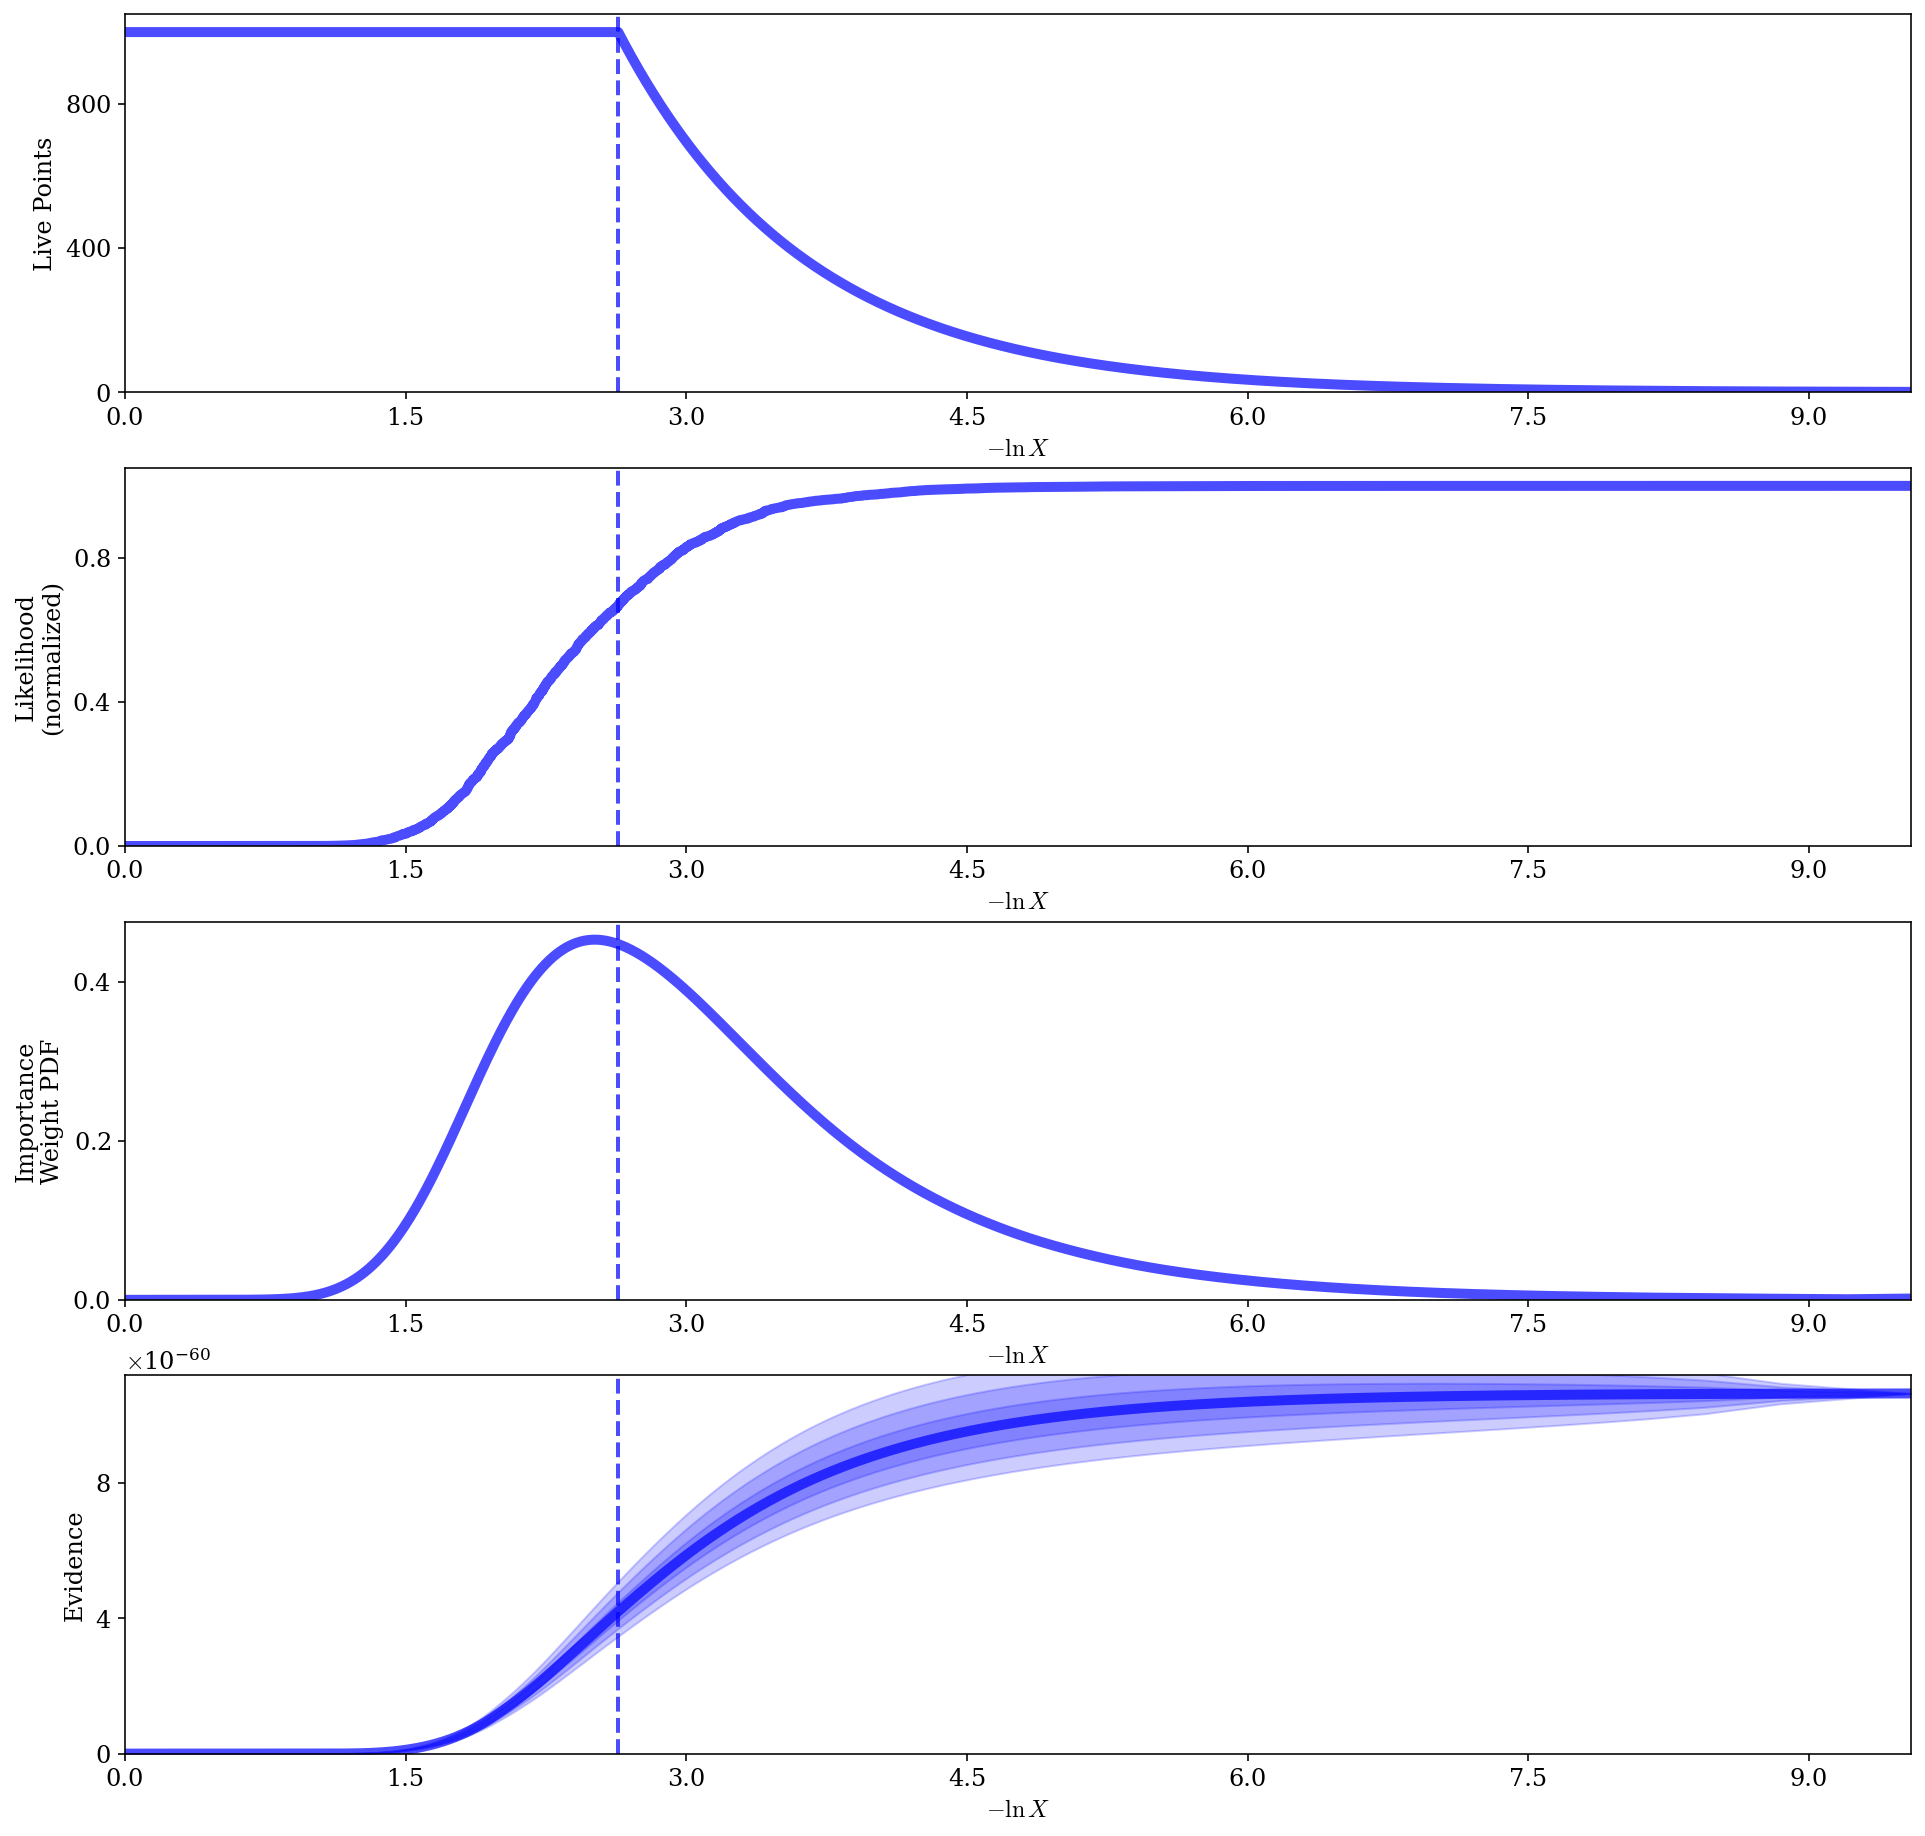

In [38]:
rfig, raxes = dyplot.runplot(results_dm)

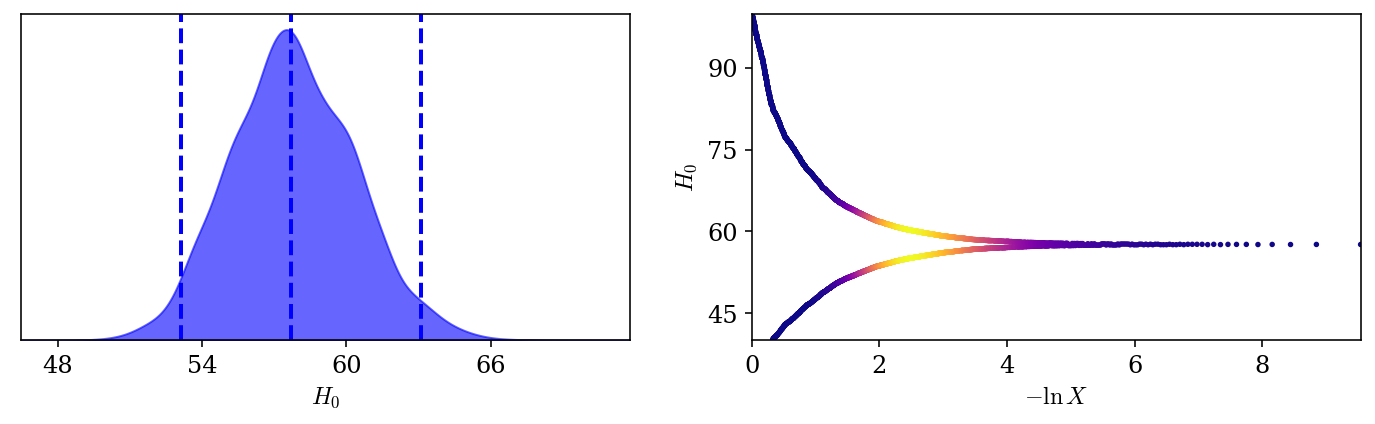

In [39]:
tfig, taxes = dyplot.traceplot(results_dm, labels=['$H_0$'])

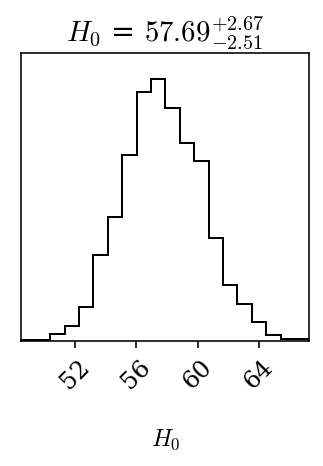

In [40]:
samples_dm = results_dm.samples  # samples
weights_dm = np.exp(results_dm.logwt - results_dm.logz[-1])  # normalized weights

samples_dm_equal = dyfunc.resample_equal(samples_dm, weights_dm)
labels = [r'$H_0$']

corner.corner(samples_dm_equal, labels=labels, show_titles=True);

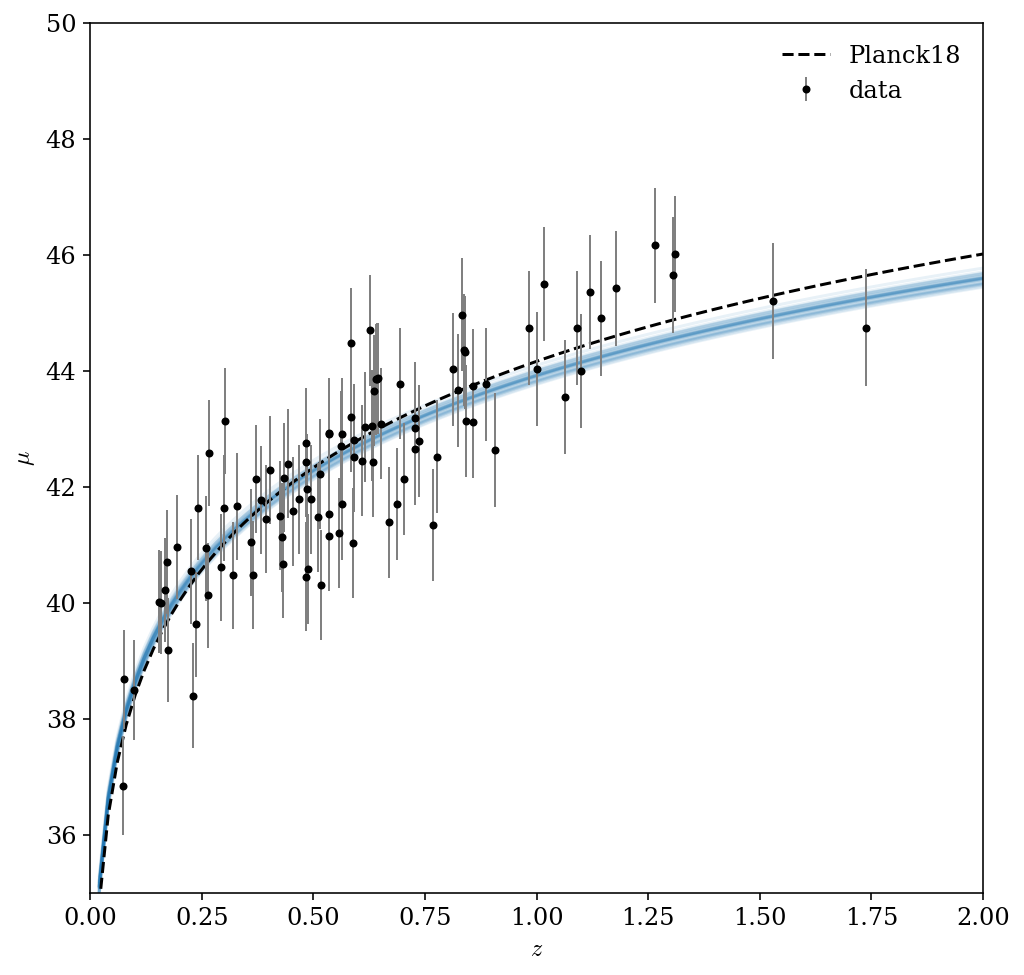

In [41]:
#30 random samples to plot
N_rand = 30
mask = np.random.choice(len(samples_dm_equal), size = N_rand)
choices = samples_dm_equal[mask][:, 0]
Om = 1

for H in choices:
    plt.plot(z_grid[1:], model(z_grid[1:], H, Om), c = 'C0', alpha = 0.1)

plt.plot(z_grid[1:], model(z_grid[1:], *true_vals), c = 'k', ls = '--', label = 'Planck18')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()

not too different: these data could be explained also by a model without dark matter and $H_0 \simeq 57 km s^{-1} Mpc^{-1}$

# Cloning data

In [42]:
z_cloning = np.random.uniform(0, 2, 500)

In [43]:
mu_clone_gpr, sigma_clone_gpr =  gpr.predict(z_cloning[:, np.newaxis], return_std=True)
mu_clone_theory = []
for z in z_cloning:
    H, O = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_clone_theory.append(model(z, H, O))

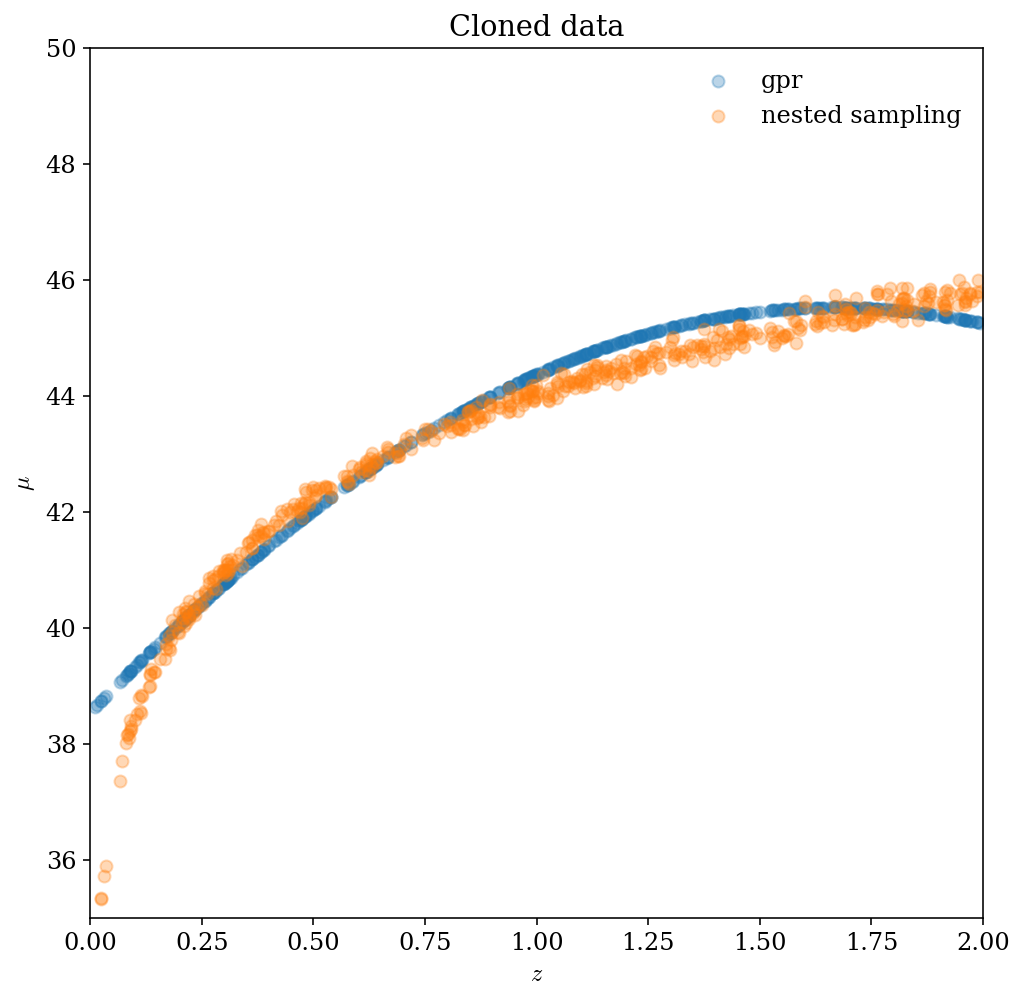

In [44]:
plt.scatter(z_cloning, mu_clone_gpr, alpha = 0.3, label = 'gpr')
plt.scatter(z_cloning, mu_clone_theory, alpha = 0.3, label = 'nested sampling')

plt.xlabel(r"$z$")
plt.ylabel("$\mu$")
plt.title('Cloned data')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(frameon = False)
plt.show()